In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/indiaminor/Shillong_Visakhapatnam_data.csv
/kaggle/input/indiaminor/Ahmedabad_data.csv
/kaggle/input/indiaminor/Aizawl_Amaravati_Amritsar_data.csv
/kaggle/input/indiaminor/Hyderabad_data.csv
/kaggle/input/indiaminor/Lucknow_data.csv
/kaggle/input/indiaminor/Bhopal_Brajrajnagar_Chandigarh_Coimbatore_data.csv
/kaggle/input/indiaminor/Chennai_data.csv
/kaggle/input/indiaminor/Patna_data.csv
/kaggle/input/indiaminor/Jorapokhar_Kochi_Kolkata_data.csv
/kaggle/input/indiaminor/Bengaluru_data.csv
/kaggle/input/indiaminor/Talcher_Thiruvananthapuram_data.csv
/kaggle/input/indiaminor/Delhi_data.csv
/kaggle/input/indiaminor/Gurugram_data.csv
/kaggle/input/indiaminor/Ernakulam_Guwahati_Jaipur_data.csv
/kaggle/input/indiaminor/Mumbai_data.csv


# LSTM

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

def preprocess_air_quality_data(file_path):
    # Load data
    df = pd.read_csv(file_path, low_memory=False)
    df.drop(columns=['City'], inplace=True)
    
    # Handle missing values
    numeric_columns = df.select_dtypes(include=['float64']).columns
    imputer = SimpleImputer(strategy='mean')
    df[numeric_columns] = imputer.fit_transform(df[numeric_columns])
    
    # Process datetime and create time features
    df['Datetime'] = pd.to_datetime(df['Datetime'], format='mixed', errors='coerce')
    df['Year'] = df['Datetime'].dt.year
    df['Month'] = df['Datetime'].dt.month
    df['Day'] = df['Datetime'].dt.day
    df['Hour'] = df['Datetime'].dt.hour
    
    # Categorize PM2.5 values
    bins = [0, 12, 35.4, 55.4, 150.4, 250.4, float('inf')]
    labels = ['Good', 'Moderate', 'Unhealthy for Sensitive', 'Unhealthy', 'Very Unhealthy', 'Hazardous']
    df['PM2.5_Category'] = pd.cut(df['PM2.5'], bins=bins, labels=labels)
    
    # Perform undersampling
    return df


# For each dataset
df = preprocess_air_quality_data('/kaggle/input/indiaminor/Delhi_data.csv')

# Print sizes to see the reduction
print("Original sizes:", len(df))

Original sizes: 48192


In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.losses import Huber


def preprocess_data(sequence_length=24):
    """
    Enhanced preprocessing pipeline with robust data cleaning
    """
    data = df
    columns_to_drop = ['AQI_Bucket', 'Datetime']
    data.drop(columns=columns_to_drop, axis=1, inplace=True)
    # Ensure numeric columns
    numeric_columns = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI']
    
#     # Convert to numeric, coerce errors to NaN
#     for col in numeric_columns:
#         data[col] = pd.to_numeric(data[col], errors='coerce')
    
    # Create datetime index
    data['datetime'] = pd.to_datetime(data[['Year', 'Month', 'Day', 'Hour']])
    data.set_index('datetime', inplace=True)
    # Handle missing values before any transformations
    numeric_columns = data.select_dtypes(include=[np.number]).columns
    data[numeric_columns] = data[numeric_columns].interpolate(method='time')
    
    # Remove outliers
    def remove_outliers(df, columns, n_std=3):
        for col in columns:
            mean = df[col].mean()
            std = df[col].std()
            df.loc[df[col] > mean + (n_std * std), col] = mean + (n_std * std)
            df.loc[df[col] < mean - (n_std * std), col] = mean - (n_std * std)
        return df
    
    data = remove_outliers(data, numeric_columns)
    
    data = pd.get_dummies(data, columns=['PM2.5_Category'], drop_first=True)
    
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    data['month'] = data.index.month
    data['is_weekend'] = data['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)
    
    # Cyclical encoding of time features
    def create_cyclical_features(df, col, period):
        df[f'{col}_sin'] = np.sin(2 * np.pi * df[col]/period)
        df[f'{col}_cos'] = np.cos(2 * np.pi * df[col]/period)
        return df
    
    data = create_cyclical_features(data, 'hour', 24)
    data = create_cyclical_features(data, 'dayofweek', 7)
    data = create_cyclical_features(data, 'month', 12)
    
    # Lag features for PM2.5
    for lag in [1, 3, 6, 12, 24]:
        data[f'pm25_lag_{lag}'] = data['PM2.5'].shift(lag)
    
    # Rolling statistics for PM2.5
    for window in [6, 12, 24]:
        data[f'pm25_roll_mean_{window}'] = data['PM2.5'].rolling(window=window).mean()
        data[f'pm25_roll_std_{window}'] = data['PM2.5'].rolling(window=window).std()
    
    # Drop rows with NaN values
    data.dropna(inplace=True)
    
    # Scale features
    scaler = RobustScaler()
    scaled_data = scaler.fit_transform(data)
    scaled_df = pd.DataFrame(scaled_data, columns=data.columns, index=data.index)
    
    # Create sequences
    X, y = [], []
    target_column_index = list(data.columns).index('PM2.5')
    
    for i in range(len(scaled_data) - sequence_length):
        X.append(scaled_data[i:i + sequence_length])
        y.append(scaled_data[i + sequence_length, target_column_index])
    
    X, y = np.array(X), np.array(y)
    
    # Split data with consideration for time series
    train_size = int(0.7 * len(X))
    val_size = int(0.15 * len(X))
    
    X_train = X[:train_size]
    X_val = X[train_size:train_size + val_size]
    X_test = X[train_size + val_size:]
    
    y_train = y[:train_size]
    y_val = y[train_size:train_size + val_size]
    y_test = y[train_size + val_size:]
    
    return (X_train, X_val, X_test, y_train, y_val, y_test, 
            scaler, data.columns, target_column_index)


def build_simplified_model(input_shape):
    """
    Simplified LSTM model with two LSTM layers and basic regularization
    """
    model = tf.keras.Sequential()

    # First LSTM layer
    model.add(tf.keras.layers.LSTM(
        units=64,  
        return_sequences=True,  
        input_shape=input_shape,
        kernel_regularizer=tf.keras.regularizers.l2(1e-4) 
    ))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.2))  

    # Second LSTM layer
    model.add(tf.keras.layers.LSTM(
        units=64,  
        return_sequences=False,  
        kernel_regularizer=tf.keras.regularizers.l2(1e-4) 
    ))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.2))  

    # Dense layer
    model.add(tf.keras.layers.Dense(32, activation='relu'))  
    model.add(tf.keras.layers.Dropout(0.2)) 
    
    # Output layer
    model.add(tf.keras.layers.Dense(1))

    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),  
        loss=Huber(),
        metrics=['mae', 'mse']
    )

    return model


def train_and_predict(X_train, X_val, X_test, y_train, y_val, y_test, scaler, data_columns, target_column_index):
    """
    Complete training and prediction pipeline
    """
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-6
        ),
        tf.keras.callbacks.ModelCheckpoint(
            'best_model.keras',
            monitor='val_loss',
            save_best_only=True
        )
    ]

    model = build_simplified_model((X_train.shape[1], X_train.shape[2]))

    history = model.fit(
        X_train, y_train,
        epochs=15,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1
    )

    def inverse_transform_predictions(predictions, scaler, data_columns, target_column_index):
        dummy = np.zeros((len(predictions), len(data_columns)))
        dummy[:, target_column_index] = predictions.flatten()
        return scaler.inverse_transform(dummy)[:, target_column_index]

    predictions = model.predict(X_test)
    predictions_orig = inverse_transform_predictions(
        predictions, scaler, data_columns, target_column_index
    )
    y_test_orig = inverse_transform_predictions(
        y_test.reshape(-1, 1), scaler, data_columns, target_column_index
    )

    return model, history, predictions_orig, y_test_orig

def save_model_artifacts(model, scaler, base_path='./'):
    """
    Save both the trained model and scaler
    """
    os.makedirs(base_path, exist_ok=True)
    
    model_path = os.path.join(base_path, 'best_lstm_model.keras')
    scaler_path = os.path.join(base_path, 'scaler.pkl')
    
    model.save(model_path)
    joblib.dump(scaler, scaler_path)
    
    print(f"Model saved to: {model_path}")
    print(f"Scaler saved to: {scaler_path}")
    
    return model_path, scaler_path


def evaluate_predictions(y_true, y_pred, dates=None):
    """
    Comprehensive evaluation of predictions with enhanced visualization
    """
    metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred),
        'MAPE': np.mean(np.abs((y_true - y_pred) / y_true)) * 100,
        'Mean Bias Error': np.mean(y_pred - y_true),
        'Max Error': np.max(np.abs(y_pred - y_true)),
        'Error Std': np.std(y_pred - y_true)
    }
    
    metrics_df = pd.DataFrame(list(metrics.items()), columns=['Metric', 'Value'])
    print("\nEvaluation Metrics:")
    print(metrics_df.to_string(index=False))
    
    plt.figure(figsize=(20, 16))

    # Time Series Plot
    plt.subplot(2, 2, 1)
    if dates is not None:
        plt.plot(dates[:200], y_true[:200], label='Actual', color='b', alpha=0.7)
        plt.plot(dates[:200], y_pred[:200], label='Predicted', color='r', alpha=0.7)
    else:
        plt.plot(y_true[:200], label='Actual', color='b', alpha=0.7)
        plt.plot(y_pred[:200], label='Predicted', color='r', alpha=0.7)
    plt.title('Time Series Plot (First 200 samples)', fontsize=14)
    plt.xlabel('Date' if dates is not None else 'Index', fontsize=12)
    plt.ylabel('PM2.5 Value', fontsize=12)
    plt.legend()
    plt.grid(True)
    
    # Scatter Plot
    plt.subplot(2, 2, 2)
    plt.scatter(y_true, y_pred, alpha=0.6, color='purple', edgecolors='k')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', label='Perfect Fit')
    plt.xlabel('Actual PM2.5', fontsize=12)
    plt.ylabel('Predicted PM2.5', fontsize=12)
    plt.title('Actual vs Predicted', fontsize=14)
    plt.legend()
    plt.grid(True)

    # Error Distribution
    plt.subplot(2, 2, 3)
    errors = y_pred - y_true
    plt.hist(errors, bins=30, color='green', alpha=0.7)
    plt.axvline(x=0, color='red', linestyle='--', label='Zero Error')
    plt.title('Error Distribution', fontsize=14)
    plt.xlabel('Prediction Error', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.legend()
    plt.grid(True)

    # Residual Plot
    plt.subplot(2, 2, 4)
    plt.scatter(y_pred, errors, alpha=0.6, color='orange', edgecolors='k')
    plt.axhline(y=0, color='red', linestyle='--', label='Zero Residual')
    plt.title('Residual Plot', fontsize=14)
    plt.xlabel('Predicted PM2.5', fontsize=12)
    plt.ylabel('Residuals', fontsize=12)
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    
    return metrics

Epoch 1/15
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - loss: 0.2171 - mae: 0.4821 - mse: 0.4622 - val_loss: 0.0442 - val_mae: 0.1780 - val_mse: 0.0558 - learning_rate: 0.0010
Epoch 2/15
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0772 - mae: 0.2511 - mse: 0.1302 - val_loss: 0.0296 - val_mae: 0.1347 - val_mse: 0.0321 - learning_rate: 0.0010
Epoch 3/15
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0633 - mae: 0.2189 - mse: 0.1096 - val_loss: 0.0224 - val_mae: 0.1054 - val_mse: 0.0238 - learning_rate: 0.0010
Epoch 4/15
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0574 - mae: 0.2107 - mse: 0.1029 - val_loss: 0.0209 - val_mae: 0.1210 - val_mse: 0.0258 - learning_rate: 0.0010
Epoch 5/15
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0526 - mae: 0.2031 - mse: 0.0973 - val_loss: 0.0152 - val_mae: 0.0944 - val_mse: 0.0178 - learning_rate: 0.0010
Epoch 6/15
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0483 - mae: 0.1970 - mse: 0.0911 - val_loss: 0.0126 - v

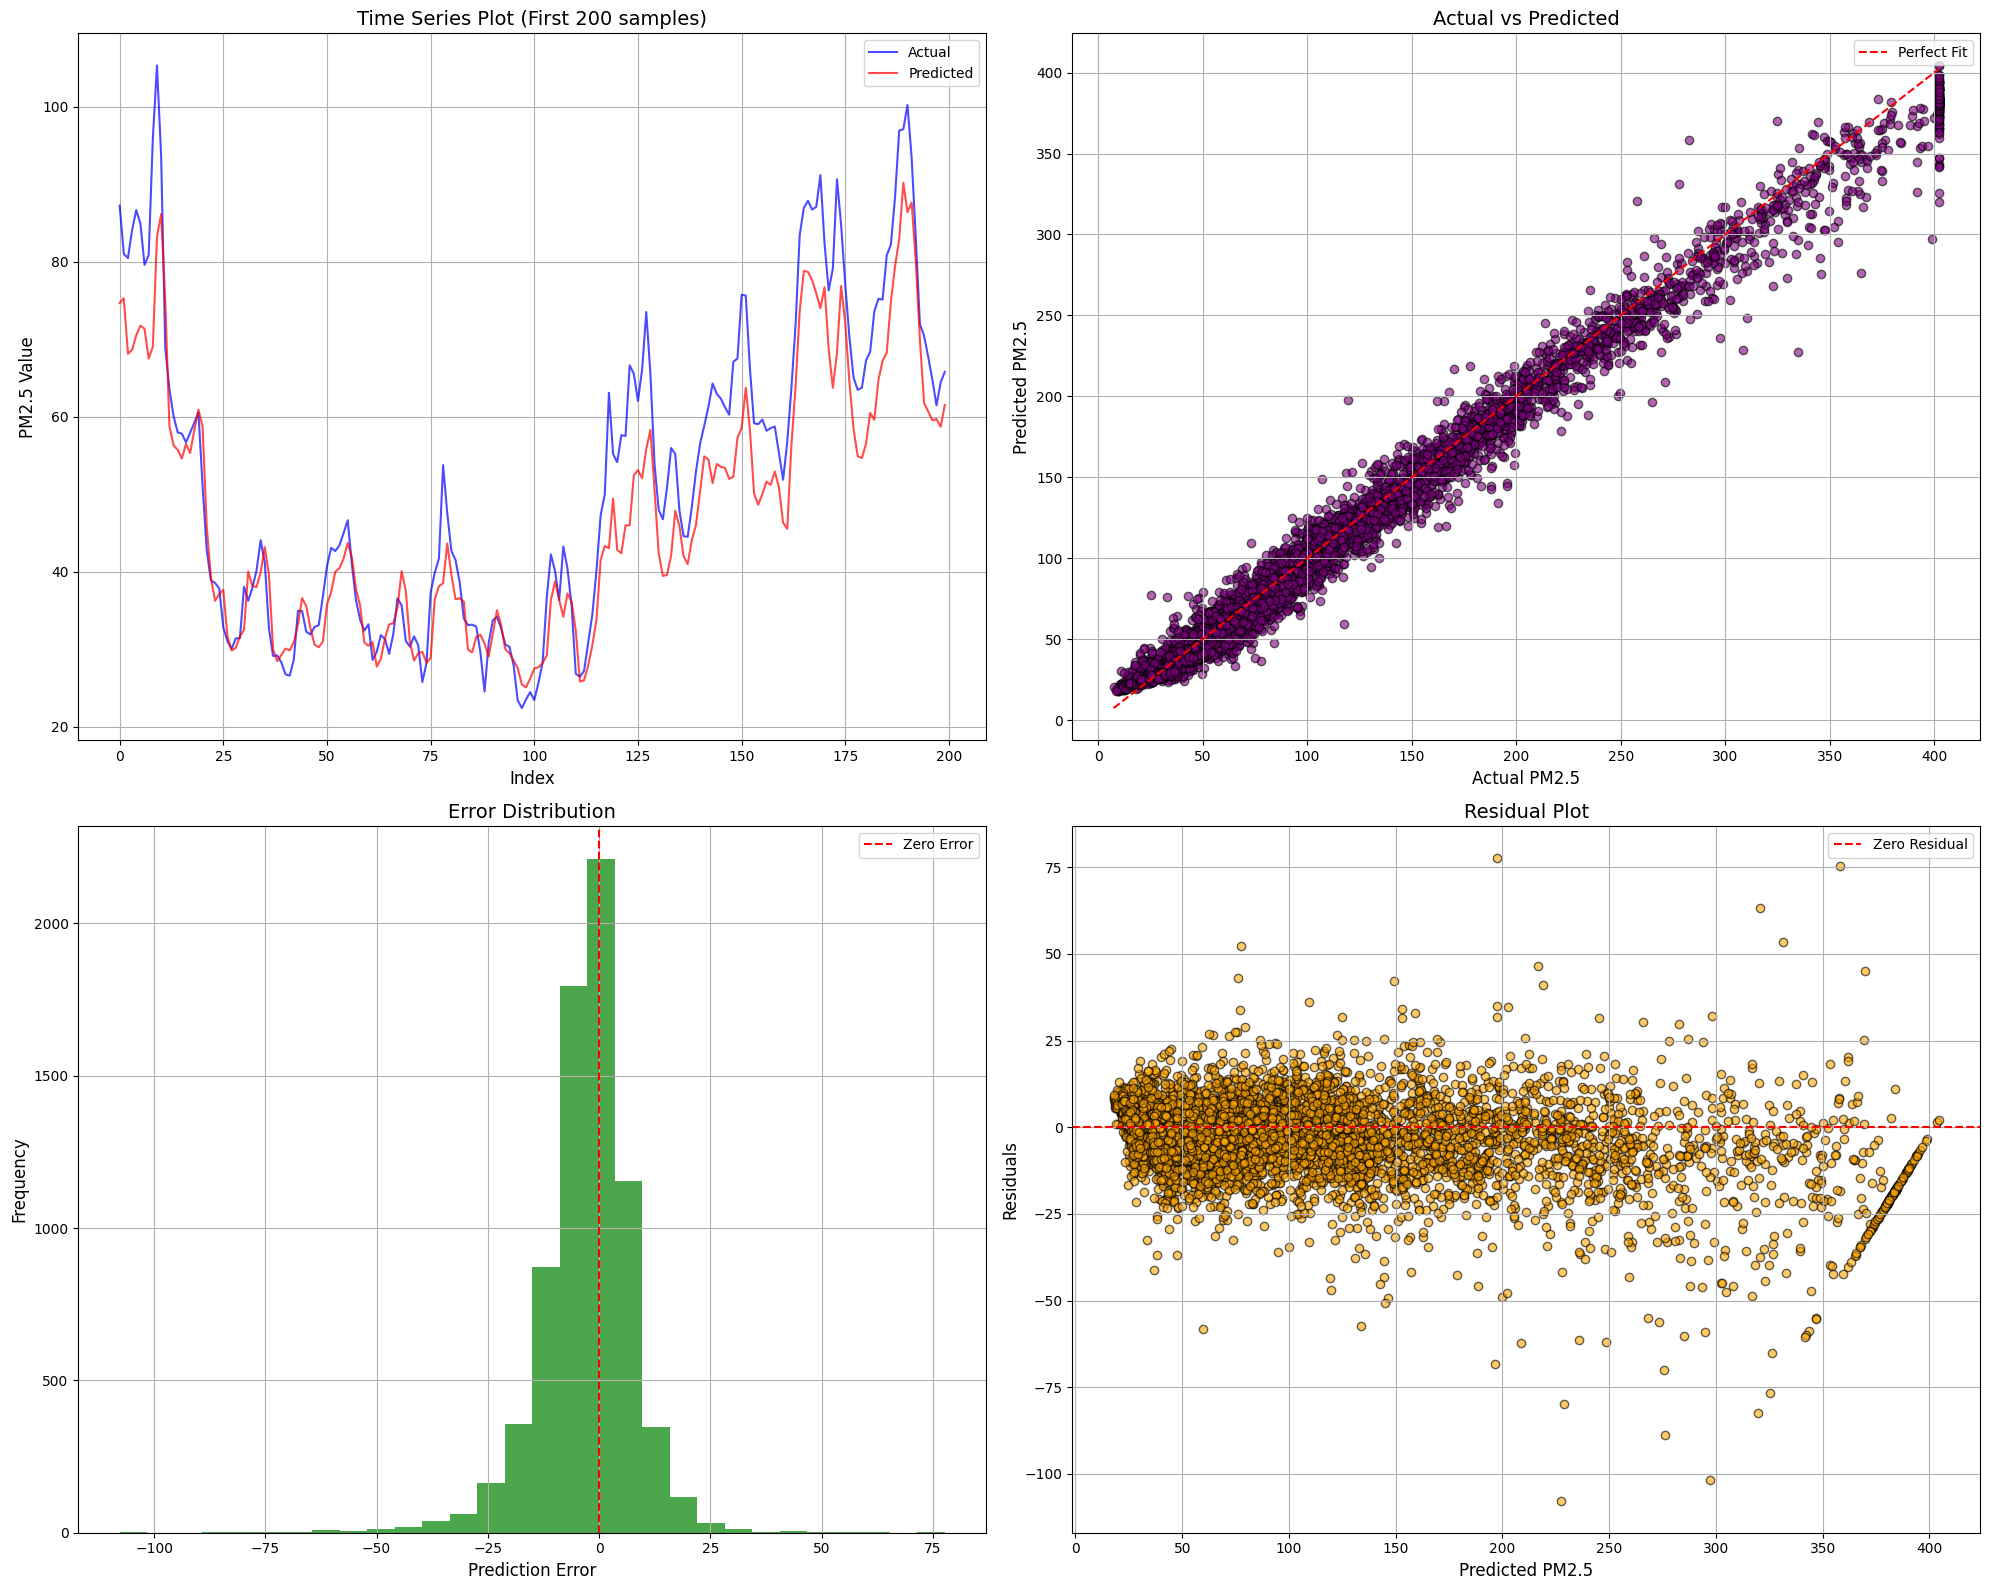

{'RMSE': 10.962432716111268,
 'MAE': 7.5509181927718,
 'R2': 0.9847875977942421,
 'MAPE': 10.384279280231592,
 'Mean Bias Error': -2.7994210107574666,
 'Max Error': 107.7288677173853,
 'Error Std': 10.59897037734309}

In [4]:

X_train, X_val, X_test, y_train, y_val, y_test, scaler, columns, target_idx = preprocess_data(
    sequence_length=24
)

# Train model and get predictions
model, history, predictions, actual = train_and_predict(
    X_train, X_val, X_test, y_train, y_val, y_test, scaler, columns, target_idx
)

# Save model artifacts
save_model_artifacts(model, scaler)

# Evaluate predictions
evaluate_predictions(actual, predictions)

# LSTM And Random Forest

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Attention, Concatenate, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Load Dataset
file_path = "/kaggle/input/indiaminor/Delhi_data.csv"  # Replace with your file path
df = pd.read_csv(file_path)

print(df.head())
df.drop(columns=['City'], inplace=True)
df['Datetime'] = pd.to_datetime(df['Datetime'], format='mixed', errors='coerce')
df['Year'] = df['Datetime'].dt.year
df['Month'] = df['Datetime'].dt.month
df['Day'] = df['Datetime'].dt.day
df['Hour'] = df['Datetime'].dt.hour
# Handle Missing Values
df.fillna(method='ffill', inplace=True)  # Forward-fill for missing values
df.fillna(method='bfill', inplace=True)  # Backward-fill as a fallback

# Encode Categorical Data
label_encoder = LabelEncoder()

# Feature Engineering
df.set_index('Datetime', inplace=True)

# Lag Features (e.g., PM2.5 of previous hours)
for lag in [1, 3, 6, 12, 24]:
    df[f'PM2.5_lag_{lag}'] = df['PM2.5'].shift(lag)

# Rolling Statistics
df['PM2.5_roll_mean'] = df['PM2.5'].rolling(window=3).mean()
df['PM2.5_roll_std'] = df['PM2.5'].rolling(window=3).std()

# Drop Rows with NaNs from Lag Features
df.dropna(inplace=True)

# Select Features and Target
features = ['PM10', 'NO', 'NO2', 'NOx', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI'] + \
           [f'PM2.5_lag_{lag}' for lag in [1, 3, 6, 12, 24]] + ['PM2.5_roll_mean', 'PM2.5_roll_std']
target = 'PM2.5'

X = df[features]
y = df[target]

# Normalize Data
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Reshape for LSTM (Samples, Timesteps, Features)
timesteps = 24  # Use last 24 hours for prediction
X_lstm = np.array([X_scaled[i - timesteps:i] for i in range(timesteps, len(X_scaled))])
y_lstm = y_scaled[timesteps:]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42, shuffle=False)

    City             Datetime   PM2.5    PM10      NO    NO2     NOx    NH3  \
0  Delhi  2015-01-01 01:00:00  454.58  935.18   81.52  41.78  187.66  27.54   
1  Delhi  2015-01-01 02:00:00  440.44     NaN   70.80  43.46  176.83  27.72   
2  Delhi  2015-01-01 03:00:00  409.09     NaN  132.46  41.19  141.02  28.94   
3  Delhi  2015-01-01 04:00:00  436.12     NaN   84.78  39.55  102.84  29.30   
4  Delhi  2015-01-01 05:00:00  415.88  976.99   60.24  37.41   80.12  30.84   

      CO   SO2     O3  Benzene  Toluene  Xylene  AQI AQI_Bucket  
0   9.29  3.41  54.94    25.24    58.57   13.80  NaN        NaN  
1  13.28  3.88  50.53    23.10    49.37   15.63  NaN        NaN  
2  29.67  2.83  19.33    19.04    38.94   17.18  NaN        NaN  
3  21.76  4.33  20.08    13.99    27.53   16.82  NaN        NaN  
4  26.19  6.17  16.00    11.14    21.99   14.29  NaN        NaN  


In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# LSTM Feature Extraction
def build_lstm_feature_model(timesteps, features):
    inputs = Input(shape=(timesteps, features))
    lstm_out = LSTM(128, return_sequences=False)(inputs)
    dense_out = Dense(64, activation='relu')(lstm_out)
    outputs = Dense(1, activation='linear')(dense_out)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Build and Train LSTM
lstm_model = build_lstm_feature_model(timesteps, X_train.shape[2])
lstm_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=15,
    batch_size=32,
    verbose=1
)

# Extract LSTM Features
lstm_train_features = lstm_model.predict(X_train)
lstm_test_features = lstm_model.predict(X_test)

# Combine LSTM Outputs with Original Features
X_train_combined = np.hstack([lstm_train_features, X_train[:, -1, :]])  # Last timestep for static features
X_test_combined = np.hstack([lstm_test_features, X_test[:, -1, :]])

# Train Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_combined, y_train.ravel())

# Make Predictions
y_pred = rf.predict(X_test_combined)

# Rescale Predictions and Ground Truth
y_pred_rescaled = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_rescaled = scaler_y.inverse_transform(y_test)

# Evaluate Performance
r2 = r2_score(y_test_rescaled, y_pred_rescaled)
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
mape = np.mean(np.abs((y_pred_rescaled - y_test_rescaled) / y_pred_rescaled)) * 100

print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4f}")

Epoch 1/15
1204/1204 ━━━━━━━━━━━━━━━━━━━━ 28s 22ms/step - loss: 0.0019 - mae: 0.0272 - val_loss: 3.3255e-04 - val_mae: 0.0110
Epoch 2/15
1204/1204 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - loss: 0.0012 - mae: 0.0196 - val_loss: 2.8098e-04 - val_mae: 0.0096
Epoch 3/15
1204/1204 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - loss: 0.0011 - mae: 0.0184 - val_loss: 3.4808e-04 - val_mae: 0.0128
Epoch 4/15
1204/1204 ━━━━━━━━━━━━━━━━━━━━ 26s 22ms/step - loss: 0.0010 - mae: 0.0174 - val_loss: 2.1239e-04 - val_mae: 0.0093
Epoch 5/15
1204/1204 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - loss: 0.0010 - mae: 0.0171 - val_loss: 1.9803e-04 - val_mae: 0.0093
Epoch 6/15
1204/1204 ━━━━━━━━━━━━━━━━━━━━ 26s 22ms/step - loss: 8.8925e-04 - mae: 0.0167 - val_loss: 1.6950e-04 - val_mae: 0.0077
Epoch 7/15
1204/1204 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - loss: 8.9046e-04 - mae: 0.0160 - val_loss: 1.7250e-04 - val_mae: 0.0078
Epoch 8/15
1204/1204 ━━━━━━━━━━━━━━━━━━━━ 26s 22ms/step - loss: 9.3667e-04 - mae: 0.0162 - val_loss: 1.7096e-0

# XGBoost

In [5]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

def set_seed(seed=42):
    """Set random seed for reproducibility"""
    np.random.seed(seed)
    
def preprocess_data(file_path):
    """Enhanced data preprocessing"""
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Drop unnecessary columns
    df.drop(columns=['City', 'AQI_Bucket'], inplace=True, errors='ignore')
    
    # Convert Datetime and extract features
    df['Datetime'] = pd.to_datetime(df['Datetime'], format='mixed', errors='coerce')
    df['Year'] = df['Datetime'].dt.year
    df['Month'] = df['Datetime'].dt.month
    df['Day'] = df['Datetime'].dt.day
    df['Hour'] = df['Datetime'].dt.hour
    
    # Handle Missing Values
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    df[numeric_columns] = df[numeric_columns].fillna(method='ffill').fillna(method='bfill')
    
    # Categorize PM2.5
    bins = [0, 12, 35.4, 55.4, 150.4, 250.4, float('inf')]
    labels = ['Good', 'Moderate', 'Unhealthy for Sensitive', 'Unhealthy', 'Very Unhealthy', 'Hazardous']
    df['PM2.5_Category'] = pd.cut(df['PM2.5'], bins=bins, labels=labels)
    
    # One-hot encode the category
    df = pd.get_dummies(df, columns=['PM2.5_Category'], drop_first=True)
    
    # Separate target and features
    y = df['PM2.5']
    X = df.drop(['PM2.5', 'Datetime'], axis=1)
    
    return X, y

def train_and_evaluate_model(X, y, n_iterations=5):
    """
    Train the model multiple times and aggregate results
    
    Args:
        X (np.array): Feature matrix
        y (pd.Series): Target variable
        n_iterations (int): Number of times to repeat training
    
    Returns:
        dict: Metrics across iterations
    """
    # Scale features
    scaler = StandardScaler()
    
    # Metrics storage
    results = {
        'rmse': [],
        'mae': [],
        'mape': [],
        'r2': []
    }
    
    for i in range(n_iterations):
        set_seed(42 + i)  # Slightly different seed each time
        
        # Scale features
        X_scaled = scaler.fit_transform(X)
        
        # Reduce dataset size
        sampled_indices = np.random.choice(
            len(X_scaled), 
            size=int(0.3 * len(X_scaled)), 
            replace=False
        )
        X_sampled = X_scaled[sampled_indices]
        y_sampled = y.iloc[sampled_indices]
        
        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(
            X_sampled, y_sampled, test_size=0.3, random_state=42, shuffle=True
        )
        X_val, X_test, y_val, y_test = train_test_split(
            X_test, y_test, test_size=0.5, random_state=42, shuffle=True
        )
        
        # Train XGBoost model
        model = xgb.XGBRegressor(
            n_estimators=1000,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42
        )
        
        # Fit the model
        model.fit(
            X_train, y_train, 
            eval_set=[(X_val, y_val)], 
            early_stopping_rounds=20,
            verbose=0
        )
        
        # Predict and evaluate
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
        r2 = r2_score(y_test, y_pred)
        
        # Store results
        results['rmse'].append(rmse)
        results['mae'].append(mae)
        results['mape'].append(mape)
        results['r2'].append(r2)
        
    return results

def cross_validation(X, y, n_splits=5):
    """
    Perform k-fold cross-validation
    
    Args:
        X (np.array): Feature matrix
        y (pd.Series): Target variable
        n_splits (int): Number of cross-validation splits
    
    Returns:
        dict: Cross-validation scores
    """
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # XGBoost model
    model = xgb.XGBRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    
    # K-Fold Cross-Validation
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # Perform cross-validation
    r2_scores = cross_val_score(model, X_scaled, y, cv=kf, scoring='r2')
    rmse_scores = -cross_val_score(model, X_scaled, y, cv=kf, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(rmse_scores)
    
    return {
        'r2_mean': r2_scores.mean(),
        'r2_std': r2_scores.std(),
        'rmse_mean': rmse_scores.mean(),
        'rmse_std': rmse_scores.std()
    }

def main():
    # Replace with your actual file path
    file_path = "/kaggle/input/indiaminor/Delhi_data.csv"
    
    # Preprocess data
    X, y = preprocess_data(file_path)
    
    # Multiple iterations
    print("Multiple Iterations Results:")
    results = train_and_evaluate_model(X, y)
    
    # Print iteration results
    for metric, values in results.items():
        print(f"{metric.upper()} - Mean: {np.mean(values):.4f}, Std: {np.std(values):.4f}")
    

if __name__ == "__main__":
    main()

Multiple Iterations Results:
RMSE - Mean: 19.8081, Std: 1.2278
MAE - Mean: 11.8233, Std: 0.4017
MAPE - Mean: 12.0509, Std: 0.3722
R2 - Mean: 0.9544, Std: 0.0052
